### Elementy przygotowania danych do wdrożenia modelu

Ten program przeprowadza przez etapy przygotowania opisu tekstowego przy wykorzystaniu funkcjonalności bibliotek Spacy i sklearn.
> Nie należy tego programu traktować jako wynywalnego od góry do dołu, ponieważ zawiera on w sobie prezentacje zastosowania różnych podejść, które należy rozważyć w trakcie przygotowywania modelu.


### Instalacja

In [1]:
# ładowanie podstawowych bibliotek 

import pyodbc # do łączenia się z bazą np. SQL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy # do NLP https://pypi.org/project/spacy/
import re # wyrażenia regularne
import pickle # https://docs.python.org/3/library/pickle.html
import os # do obsługi systemu https://docs.python.org/3/library/os.html

Po instalacji biblioteki spacy potrzebny nam jest dodatkowy moduł obsługujący język polski. 
<br> Instalujemy go z terminala PyCharm poleceniem: python -m spacy download pl_core_news_sm.
> Uwaga: W bibliotece Spacy są trzy moduły do obsługi języka polskiego. 
<br>     Dokumentacja na stronie : https://spacy.io/models/pl. 

Moduł, który wybrałem jest wg. dokumentacji najmniejszy i działa jak na moje potrzeby OK. Stąd decyzja ten a nie inny. 

### Pobranie danych z servera

In [2]:
os.getcwd()

'C:\\Users\\DabrowskiD\\PycharmProjects\\Jupyter\\venv\\dokumentacja ML'

### w poniższym spróbujcie zrobić tak żeby lokalizację zbioru brał automatycznie z wyniku powyższej funkcji ;)

In [2]:
# zmienna report.descr zawiera opisy nieruchomości wystawionych na sprzedaż
# zmienna classification.kitch_class i secure_class to zaklasyfikowane ręcznie informacje
a = 'model_df'
df=pd.read_pickle(f'C:\\Users\\DabrowskiD\\PycharmProjects\\Jupyter\\venv\\MEBLE_ML\\regresja\\{a}.pkl')

# Przegląd wartości znajdujących się w zmiennej  kitch_class

labels = np.unique(df['furniture_class'])
labels


array(['brak informacji', 'nie       ', 'tak       '], dtype=object)

In [3]:
# ponieważ chcemy uzyskac odpowiedź na pytanie czy mieszkanie jest umeblowane to musimy się zastanowić jakie
# informacje usunąć. Po zapoznaniu się z wynikami poprzedniego polecenia usuwam rekordy dla następujących warunków:
# 'furniture_class' == 'brak informacji'
# w ten sposób pozostawiamy tylko te wartości, które niosą konkretną informację odnośnie umeblowania

df.drop(df.index[df['furniture_class'] == 'brak informacji'], inplace=True)
labels = np.unique(df['furniture_class'])
labels

array(['nie       ', 'tak       '], dtype=object)

### Przygotowanie danych
Przetwarzając dane w DF niestety jesteśmy ograniczeni jej właściwościami. Uruchamiając polecenie type(df['descr']) można zauwazyc, że w wyniku nie otrzymujemy informacji, że jest to string ale pandas.core.series.Series. I to przy przetwarzaniu nasuwa pewne ograniczenia. Można oczywiście przekonwertować informację zawartą w każdej celi na string i obrabiac dane ale cały proces jest nieefektywny i trwa bardzo długo. Stąd w obróbce danych będziemy wykorzystywać atrybuty serii DF a konkretnie dwa: str i apply w połączeniu z funkcjami lambda. 


In [6]:
type(df['descr'])

pandas.core.series.Series

#### Konwersja na małe znaki. 
W przypadku tych danych wielkość liter nie ma wpływu na klasyfikację.

In [4]:
df['descr'] = df['descr'].str.lower()
df['descr'].head()

0     już dostępna kameralna kawalerka z klimatyzac...
2     uwaga najem okazjonalny prosimy o kontakt tyl...
4    m2 27m2 dąbrowa umeblowane wyposażone bliskość...
5     nowoczesne mieszkanie po remoncie oferujemy d...
6     oferuję do wynajęcia przepiękne świeżo wyremo...
Name: descr, dtype: object

#### Usuwanie zbędnych znaków

Wykorzystamy do tego Regex. 
> Co prawda dalsze etapy obróbki tekstu pozwalają na czyszczenie ale moim zdaniem, na wstępnym etapie, Regex robi to w sposób bardzie kontrolawany i kompleksowy w procesie ściśle definiowanym przez nas. Stąd ta wstępna obróbka. 

Usuniemy interpunkcję i inne dziwne znaki, które zostały wprowadzone przez przypadek. 
> Na marginesie: w regeksie podobno jest jakiś elegancki kod pozwalający uwzględnic polskie znaki ale nie chciało mi się szukać. Stąd prymitywne wymienienie ą, ę itd. jako znaki dodatkowe, które mają zostać w tekście.

In [8]:
df['descr'] = df['descr'].apply(lambda x: re.sub(r'[^A-Za-z0-9ąćęłńóśźżĄĆĘŁŃÓŚŹŻ]+',' ', str(x))) 
## dodatkowo dla chętnych - wyszukać regex do polskich znaków

#### Tokenizacja

Pamiętajmy o kolejności, warto zrobić tokenizację przed Stop Words. 
> Podobno NLTK (inna biblioteka) jest lepsza do tokenizacji, ale tu używamy Spacy. 

SpaCy posiada dużo opcji tokenizacji. 
> Poniższej celi nie należy wykonywać jeśli mamy zamiar używać CountVectorizer. CountVectorizer nie może bezpośrednio obsłużyć serii list, dlatego pojawia się błąd. Zamiast tego można użyć MultiLabelBinarizer, ale nie ma takiej potrzeby bo CV domyślnie dokonuje tokenizacji tekstu. Ponadto posiada szereg opcji, które ułatwiaja przygotowanie i transformację opisu o czym będzie dalej. 

Przykład dotyczy wykorzystania spacy do tokenizcji i został utworzony na wypadek gdyby ktoś konieczni chciał oprzeć się tylko o tą bibliotekę prz opracowywaniu tekstu.

In [15]:
from spacy.lang.pl import Polish
nlp = Polish()
# Create a Tokenizer with the default settings for Polish
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer
df['descr'] =  df['descr'].apply(lambda x: tokenizer(x))
df['descr'].head()

0    ( , już, dostępna, kameralna, kawalerka, z, kl...
2    ( , uwaga, najem, okazjonalny, prosimy, o, kon...
4    (m2, 27m2, dąbrowa, umeblowane, wyposażone, bl...
5    ( , nowoczesne, mieszkanie, po, remoncie, ofer...
6    ( , oferuję, do, wynajęcia, przepiękne, świeżo...
Name: descr, dtype: object

#### Stop Words
Czyli słowa, które nic nie wnoszą do opisu (w sensie budowy klasyfikacji), a przy tworzeniu modelu mogą wprowadzać szumy. 
Najczęściej występują w formie dokumentu tekstowego, w którym są wymienione słowa niepotrzebne z punktu widzenia treści. Oczywiście możemy definiować swój plik ze słowami niechcianymi i do niego się odwoływać. Stop words może byc też krótką listą zdefiniowaną przez nas. W poniższym kodzie odwołuję się do pliku zdefiniowanego w polskim modelu SpaCy. Najpierw ładuję polski model, a następnie przypisuję do zmiennej stopwords standardowy plik z modelu. Słownik ten wykorzystuję równiez w prosty sposób przy obróbce tekstu przez CountVectorizer.

In [5]:
# Przyjrzyjmy sie funkcjonalności funkcji stopwords oraz spsobom modyfikacji listy słów. Przed zapuszczeniem stopwords konieczna
# jest np. tokenizacja która zmienia string w listę. Inaczej będą ciekawe efekty zapuszczenia stopwords.  

# z biblioteki Spacy łaldujemy słownik 
pl=spacy.load("pl_core_news_sm")

# tu ładujemy słownik stopwordsów do zmiennej stopwords
stopwords = pl.Defaults.stop_words

# testujemy typ zmiennej 
print(type(stopwords))

# typ zmiennej to Set. Wykorzystamy więc metody związane z Set-ami do zarządzania i modyfikacji listy wyrażeń do przetwarzania

<class 'set'>


In [6]:
# przegląd wyrażeń w zmiennej stopwords
print(stopwords)

{'byly', 'się', 'im', 'według', 'około', 'ach', 'cokolwiek', 'to', 'moja', 'ktorym', 'mnie', 'ten', 'my', 'sobą', 'twoim', 'tam', 'mają', 'która', 'ktorych', 'teraz', 'albo', 'jesli', 'przede', 'jest', 'być', 'az', 'trzeba', 'nim', 'raz', 'od', 'nasi', 'nam', 'jedno', 'i', 'juz', 'ono', 'już', 'duzo', 'skąd', 'sama', 'toteż', 'w', 'wasze', 'ix', 'totez', 'dwaj', 'gdzie', 'będę', 'na', 'on', 'xii', 'dużo', 'nas', 'jakoś', 'powinni', 'zadna', 'coś', 'tzw', 'kims', 'niemu', 'dwoje', 'takie', 'bede', 'cała', 'vii', 'były', 'jakiz', 'którym', 'taki', 'jednym', 'który', 'może', 'był', 'naszego', 'kto', 'niż', 'viii', 'ktory', 'dosc', 'nasz', 'byc', 'inna', 'one', 'znowu', 'że', 'ich', 'o', 'innych', 'nami', 'znów', 'zadne', 'jednakże', 'go', 'było', 'miał', 'wszystkie', 'cały', 'swoje', 'nich', 'niego', 'chce', 'poniewaz', 'takze', 'ktorzy', 'ktoś', 'nad', 'nic', 'jakas', 'taka', 'dlatego', 'także', 'ci', 'zawsze', 'takich', 'jestem', 'wtedy', 'poza', 'acz', 'jaki', 'mało', 'wszystko', 'sie'

In [12]:
# liczba wyrażeń w stopwords
print(len(stopwords))

381


In [7]:
# dodawanie wyrażeń do pierwotnego zestawienia tj. tych które chcemy usunąć np. z opisu. 
# Wyrazy z Bag_of_words uzyskane w dalszej części kodu

stop2 = {'m2', 'pl', 'zł', 'zapraszam', 'the', 'nr',}
stopwords = stopwords.union(stop2)
lista = list(stopwords)

print(stopwords)
print(len(stopwords))

{'byly', 'się', 'tych', 'ktorego', 'im', 'inne', 'według', 'około', 'ach', 'żeby', 'cokolwiek', 'to', 'moja', 'ktorym', 'mnie', 'ten', 'byl', 'jemu', 'my', 'twoje', 'możliwe', 'wiele', 'u', 'moi', 'by', 'sobą', 'twoim', 'bylo', 'dlaczego', 'tam', 'mają', 'wszystkim', 'wlasnie', 'twoj', 'która', 'ktorych', 'teraz', 'toba', 'a', 'albo', 'jesli', 'przede', 'nimi', 'pani', 'jest', 'być', 'żadne', 'czasem', 'az', 'trzeba', 'nim', 'tutaj', 'm2', 'raz', 'od', 'pl', 'nasi', 'nam', 'jakichs', 'zapewne', 'wasz', 'jedno', 'ja', 'ktorej', 'i', 'ty', 'oto', 'nr', 'które', 'zeby', 'juz', 'ono', 'roku', 'bedzie', 'już', 'duzo', 'skąd', 'sama', 'toteż', 'w', 'wasze', 'podczas', 'do', 'alez', 'mój', 'nasza', 'jakichś', 'jej', 'xi', 'ix', 'totez', 'dwaj', 'gdzie', 'gdyz', 'będę', 'lecz', 'na', 'cie', 'on', 'xii', 'kilku', 'dużo', 'caly', 'nas', 'jakoś', 'powinni', 'nasze', 'cala', 'bo', 'mogą', 'zadna', 'którzy', 'coś', 'znow', 'tzw', 'mu', 'byli', 'kims', 'mna', 'gdyż', 'twoi', 'niemu', 'dwoje', 'takie

In [8]:
# odejmowanie wyrażeń z pierwotnego zestawienia tj. tych wyrażeń których nie chcemy usunąć np z opisu. Tu odejme  pięć 
stop2 = {'iz', 'swoje', 'było', 'często', 'godz'}
stopwords = stopwords.difference(stop2)

print(stopwords)
print(len(stopwords))

{'byly', 'się', 'tych', 'ktorego', 'im', 'inne', 'według', 'około', 'ach', 'żeby', 'cokolwiek', 'to', 'moja', 'ktorym', 'mnie', 'ten', 'byl', 'jemu', 'my', 'twoje', 'możliwe', 'wiele', 'u', 'moi', 'by', 'sobą', 'twoim', 'bylo', 'dlaczego', 'tam', 'mają', 'wszystkim', 'wlasnie', 'twoj', 'która', 'ktorych', 'teraz', 'toba', 'a', 'albo', 'jesli', 'przede', 'nimi', 'pani', 'jest', 'być', 'żadne', 'czasem', 'az', 'trzeba', 'nim', 'tutaj', 'm2', 'raz', 'od', 'pl', 'nasi', 'nam', 'jakichs', 'zapewne', 'wasz', 'jedno', 'ja', 'ktorej', 'i', 'ty', 'oto', 'nr', 'które', 'zeby', 'juz', 'ono', 'roku', 'bedzie', 'już', 'duzo', 'skąd', 'sama', 'toteż', 'w', 'wasze', 'podczas', 'do', 'alez', 'mój', 'nasza', 'jakichś', 'jej', 'xi', 'ix', 'totez', 'dwaj', 'gdzie', 'gdyz', 'będę', 'lecz', 'na', 'cie', 'on', 'xii', 'kilku', 'dużo', 'caly', 'nas', 'jakoś', 'powinni', 'nasze', 'cala', 'bo', 'mogą', 'zadna', 'którzy', 'coś', 'znow', 'tzw', 'mu', 'byli', 'kims', 'mna', 'gdyż', 'twoi', 'niemu', 'dwoje', 'takie

#### Zastosowanie wbudowanych funkcji CountVectorizer() do odcięcia mało licznych słów
Czasami transformacja i wykorzystanie całego słownictwa zawartego w opisie nie jest efektywne, ponieważ dane mogą zawierać  wyjątkowo rzadkie lub niechciane słowa, które przekazane do TfidfVectorizer().fit() dodadzą w przyszłości niechciane wymiary do danych wejściowych. 
 
 Jedną z technik stosowanych w tym przypadku byłoby na przykład wydrukowanie częstotliwości słów w dokumentach, 
 a następnie ustawienie dla nich określonego progu. 
 
 Przykładowa analiza: wyobraźmy sobie, że ustawiliśmy próg 100, a korpus opisu danych składa się z 10000 słów. 
 Po przyjrzeniu się częstotliwości słów, 20 słów pojawia się mniej niż 100 razy. 
 To zbyt często aby te słowa usunąć. Ustawiamy max_features=200 i analizujemy wyniki. Po dobraniu odpowiedniej liczby  przy 
 max_features, gdy najniższa liczba wystąpień słów spadnie do akceptowalnych wyników można zaczynać. Liczba ta oczywiście jest
 zależna od wielkości zbioru uczącego i samego korpusu.
 Jeśli parametr max_features jest ustawiony na Brak, podczas transformacji TF-IDF uwzględniany jest cały opis.
 Tu wykorzystam tą funkcję w inny sposób. Ustawię max_features=100 i będę analizował wystąpienia słów, a ewidentnie zbędne dodam do StopWords. Przeprowadzę jedną iterację w celu demonstracji. Iteracje można powtarzać oczywiście w celu lepszego przygotowania zbioru 

 Jednakże przed wykorzystaniem możliwości CountVectorizer wykorzystamy słownik stopwords.


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=100, stop_words=lista)
wektor = vectorizer.fit_transform(df['descr'])
vectorizer.get_feature_names_out()

array(['48', 'administracyjny', 'agd', 'and', 'aneksem', 'apartament',
       'apartment', 'asari', 'asaricrm', 'balkon', 'biur', 'budynek',
       'budynku', 'cena', 'centrum', 'com', 'crm', 'cywilnego', 'czynsz',
       'dodatkowo', 'dostępne', 'for', 'garażu', 'in', 'informacje', 'is',
       'kaucja', 'kodeksu', 'kuchennym', 'kuchni', 'kuchnia', 'lodówka',
       'lokalizacja', 'meble', 'media', 'miasta', 'miejsca', 'miejsce',
       'mieszkania', 'mieszkanie', 'min', 'możliwość', 'najmu',
       'nieruchomości', 'nowe', 'numer', 'of', 'oferta', 'oferty',
       'ogrzewanie', 'opłaty', 'osób', 'park', 'pełni', 'piekarnik',
       'piętrze', 'pln', 'pobliżu', 'podziemnym', 'pokaż', 'pokojowe',
       'pokój', 'postojowe', 'powierzchni', 'pralka', 'prezentację',
       'programu', 'przedpokoju', 'przedpokój', 'prąd', 'płyta', 'room',
       'rozumieniu', 'salon', 'salonu', 'sklepy', 'składa', 'stanowi',
       'sypialni', 'sypialnia', 'szafa', 'ul', 'umeblowane', 'wc', 'wg',
       '

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Jeśli użyliśmy tokenizacji to:
# from sklearn.preprocessing import MultiLabelBinarizer
# count_vec = MultiLabelBinarizer()
# mlb = count_vec.fit(df['descr'])
# pd.DataFrame(mlb.transform(dfdf['descr']), columns=[mlb.classes_])

X=df['descr'] # tu generuje wektor opisów do analizy
count_v = CountVectorizer(max_features=100, stop_words=lista)
count_v.fit(X)



CountVectorizer(max_features=100,
                stop_words=['byly', 'się', 'tych', 'ktorego', 'im', 'inne',
                            'według', 'około', 'ach', 'żeby', 'cokolwiek', 'to',
                            'moja', 'ktorym', 'mnie', 'ten', 'byl', 'jemu',
                            'my', 'twoje', 'możliwe', 'wiele', 'u', 'moi', 'by',
                            'sobą', 'twoim', 'bylo', 'dlaczego', 'tam', ...])

#### Zastosowanie innego podejścia do wybrania mało licznych słów.
W celi poniżej alternatywna analiza występowania słów w opisie. Zliczamy wystąpienia słów w opisach
bag_of_words macierz, w której każdy wiersz reprezentuje określony tekst, a każda kolumna reprezentuje słowo w słowniku, czyli wszystkie słowa znalezione w korpusie. Czyli bag_of_words[i,j] to wystąpienie słowa j w tekście i.

In [12]:
## można zrobić też w jednym kroku fit_transform
bag_of_words = count_v.transform(X)
suma_slow = bag_of_words.sum(axis=0) # suma_slow to wektor, który zawiera sumę wystąpień każdego słowa we wszystkich tekstach 
# print(suma_slow) # tu jak ktoś ciekawy ja to wygląda pierwotnie

# Zliczanie wystąpień. W pierwszej linijce pętla zliczająca liczbę wystąpień i zwracająca parę: słowo - liczba wystąpień.
# W drugiej linijce sortowanie słów od największej liczby wystąpień do najmiejszej

words_freq = [(word, suma_slow[0, idx]) for word, idx in count_v.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq) # drukowanie i analiza



[('mieszkanie', 16082), ('nieruchomości', 8266), ('czynsz', 6243), ('numer', 6049), ('48', 5866), ('najmu', 5769), ('pokaż', 5665), ('and', 5474), ('znajduje', 5055), ('mieszkania', 5018), ('in', 4910), ('pln', 4594), ('oferty', 4459), ('centrum', 4453), ('of', 4393), ('budynku', 4215), ('łazienka', 4170), ('wynajęcia', 4049), ('ul', 4023), ('with', 3926), ('miejsce', 3898), ('kaucja', 3767), ('oferta', 3752), ('prąd', 3635), ('sypialni', 3542), ('lokalizacja', 3440), ('piętrze', 3422), ('ogrzewanie', 3394), ('łazienki', 3369), ('opłaty', 3289), ('składa', 3126), ('powierzchni', 3078), ('balkon', 3064), ('kuchnia', 3000), ('aneksem', 2999), ('pełni', 2985), ('apartment', 2981), ('salon', 2960), ('kuchennym', 2929), ('apartament', 2893), ('wc', 2750), ('is', 2736), ('wyposażone', 2700), ('sypialnia', 2669), ('rozumieniu', 2644), ('kuchni', 2621), ('umeblowane', 2609), ('piekarnik', 2584), ('salonu', 2567), ('woda', 2527), ('stanowi', 2493), ('lodówka', 2434), ('kodeksu', 2433), ('pobliż

#### Zastosowanie słownika predefiniowanego

In [13]:
# z zastosowaniem słownika
from sklearn.feature_extraction.text import CountVectorizer
slownik = ['mieszkanie', 'meble', 'kanapa']

X=df['descr'] # tu generuje wektor opisów do analizy
count_v = CountVectorizer(max_features=100, stop_words=lista, vocabulary = slownik)

bag_of_words = count_v.fit_transform(X)
suma_slow = bag_of_words.sum(axis=0)

words_freq = [(word, suma_slow[0, idx]) for word, idx in count_v.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq)


[('mieszkanie', 16082), ('meble', 2087), ('kanapa', 810)]


In [3]:
# to jest zestaw wyrazeń, które chcę dodać do stop words po analizie
stop2 = {'m2', 'pl', 'zł', 'zapraszam', 'the', 'nr',}

In [ ]:
# Ciekawostka: są dodatkowe opcje CountVectorizer. Możemy ustalić np. minimalną liczbę wystąpień poleceniem min_df 
# żeby je usunąć i zmiejszyć liczbę wymiarów
# coun_vect = CountVectorizer(min_df=10) # ustawienie limitu na 10
# count_matrix = coun_vect.fit_transform(test_x)
# count_array = count_matrix.toarray() 
# df = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names()) # tu pozyskujemy listę słów
# print(df) # tu drukujemy te słowa.

### Zastosowanie funkcji n-gram
Niektóre określenia mają większy sens gdy rozpatrujemy je jako całość, a nie jako osobne słowa.
<br> Dotyczy np. określeń: aneks kuchenny.
<br> Dlatego możemy stosować n-gramy w celu utworzenia zestawień słów umiejscowionych koło siebie w analizowanym tekście.

Implementacja w CountVectorizer przebiega prosto. W opcjach dodajemy parametr ngram_range=
Gdzie wartość range określa jakie n-gramy mają być zastosowane.
ngram_range=(1,2) dobierze każde słowo z osobna i wszystkie pary słów
ngram_range=(2,2) dobierze tylko pary słów


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=100, ngram_range=(2,2), stop_words=lista)
# Map each word in our training narratives to a vector position
vectorizer.fit(df['descr'])

# tu otrzymana lista ngramów
vectorizer.get_feature_names_out()


array(['48 pokaż', 'aneks kuchenny', 'aneksem kuchennym', 'apartment is',
       'art 66', 'asari crm', 'asaricrm com', 'biur nieruchomości',
       'biuro nieruchomości', 'cena najmu', 'centrum miasta',
       'charakter informacyjny', 'ciepła woda', 'crm asaricrm',
       'czynsz administracyjny', 'czynsz najmu', 'dodatkowe informacje',
       'dostępne zaraz', 'duży balkon', 'dwupokojowe mieszkanie',
       'garażu podziemnym', 'hali garażowej', 'handlowej rozumieniu',
       'is located', 'istnieje możliwość', 'kabina prysznicowa',
       'kaucja zwrotna', 'kodeksu cywilnego', 'komunikacji miejskiej',
       'komórka lokatorska', 'kuchennym sypialni', 'liczne sklepy',
       'living room', 'miejsce parkingowe', 'miejsce postojowe',
       'mieszkania przynależy', 'mieszkanie dostępne', 'mieszkanie pełni',
       'mieszkanie pokojowe', 'mieszkanie powierzchni',
       'mieszkanie składa', 'mieszkanie znajduje', 'możliwość wynajęcia',
       'najem okazjonalny', 'najmu okazjonalnego'

### Wdrożenie ograniczonego modelu. 
> Ten model nie jest efektywny bo analiza i korekta opisu jest przeprowadzona w celach demonstracyjnych i prezentuje funkcjonalność narzędzi. 
<br> Prezentuje również efektywność takiego podejścia. Poprzez likwidację wymiarów osiągamy znaczne oszczędności czasowe związane z wdrożeniem modelu.

In [163]:
## jeżeli to wszystko co jest w komórkach poniżej jest tym samym co w ML lub Bayessowski, to usuńmy to.
## ten dokument może pozostać tylko opisem sposobów wyboru stop wordsów i przygotowania tekstu do realizacji autoklasyfikacji.
# Tu po analizie próba znalezienia parametrów

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 

vectorizer = CountVectorizer(max_features=1200,  stop_words=lista)
# Map each word in our training narratives to a vector position
vectorizer.fit(df['descr'])
# Convert each training narrative to its vector representation and stack them into a matrix
X = vectorizer.transform(df['descr'])
X = X.toarray()
y = df['kitch_class']

# podział zbioru na 3 części. W pierwszym kroku otrzymamy 2 zbiory - uszący i treningowy z walidacyjnym. W 2 kroku dokonujemy 
# podziału zbioru testowo - walidacyjnego na dwa odrębne zbiory testowy i walidacyjny

X_train, X_test_all, y_train, y_test_all = train_test_split(X, y, test_size=0.50, random_state=2)

X_test, X_val, y_test, y_val = train_test_split(X_test_all, y_test_all, test_size=0.50, random_state=2)



In [164]:
# Dobór parametrów przy użyciu metody optymizacji Bayessowskiej. Ze względu na demonstracyjny charakter 
# ograniczę przestrzeń wyszukiwania w celu zaoszczędzenia czasu. Z drugiej strony zawężona przestrzeń poszukiwań pozwala funkcji na lepszy wybór parametrów.

# Zdefiniowanie przestrzeni poszukiwania

# Przestrzeń dla wartości C
C_range = np.logspace(-3, 3, 31) # pierwsza wartość, wartość końcowa, ilość wystąpień np.-5, 5, 21
print(f'The list of values for C are {C_range}')

# Przestrzeń dla wartości gamma
gamma_range = np.logspace(-3, 3, 31) # pierwsza wartość, wartość końcowa, ilość wystąpień np.-5, 5, 21
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [1.00000000e-03 1.58489319e-03 2.51188643e-03 3.98107171e-03
 6.30957344e-03 1.00000000e-02 1.58489319e-02 2.51188643e-02
 3.98107171e-02 6.30957344e-02 1.00000000e-01 1.58489319e-01
 2.51188643e-01 3.98107171e-01 6.30957344e-01 1.00000000e+00
 1.58489319e+00 2.51188643e+00 3.98107171e+00 6.30957344e+00
 1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03]
The list of values for gamma are [1.00000000e-03 1.58489319e-03 2.51188643e-03 3.98107171e-03
 6.30957344e-03 1.00000000e-02 1.58489319e-02 2.51188643e-02
 3.98107171e-02 6.30957344e-02 1.00000000e-01 1.58489319e-01
 2.51188643e-01 3.98107171e-01 6.30957344e-01 1.00000000e+00
 1.58489319e+00 2.51188643e+00 3.98107171e+00 6.30957344e+00
 1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.0000

In [165]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from statistics import mean

# Przestrzeń
space = {
    'C' : hp.choice('C', C_range),
    'gamma' : hp.choice('gamma', gamma_range.tolist()+['scale', 'auto']),
    'kernel' : hp.choice('kernel', ['linear', 'rbf'])
}
# W tym kroku użyjemy funkcji StratifiedKFold do podziału zbioru. Funkcja ta powala dokonac losowania stratyfikacyjnego w niezbyt
# zrównoważonych zbiorach. Zobaczymy czy zastosowanie tej funkcji pozwoli nam w sposób bardziej dokładny. () 

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Objective function
def objective(params):
    
    svc = SVC(**params)
    scores = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = mean(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = bayes_trials) # max_eval powinno być wyższe np. 200

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:43<00:00,  2.83s/trial, best loss: -0.9191607059755256]


In [166]:
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

{'C': 7, 'gamma': 32, 'kernel': 0}
{'C': 0.025118864315095808, 'gamma': 'auto', 'kernel': 'linear'}


In [167]:
from sklearn import metrics

Bayes_predict_model_SVM = SVC(C=1.0, kernel = 'linear' , gamma=0.001, random_state=42).fit(X_train,y_train)
y_pred_test = Bayes_predict_model_SVM.predict(X_test)
print(metrics.classification_report(y_test,y_pred_test))
print(metrics.accuracy_score(y_test, y_pred_test))

              precision    recall  f1-score   support

       aneks       0.91      0.91      0.91       726
     odrębna       0.83      0.84      0.84       393

    accuracy                           0.88      1119
   macro avg       0.87      0.87      0.87      1119
weighted avg       0.88      0.88      0.88      1119

0.8838248436103664


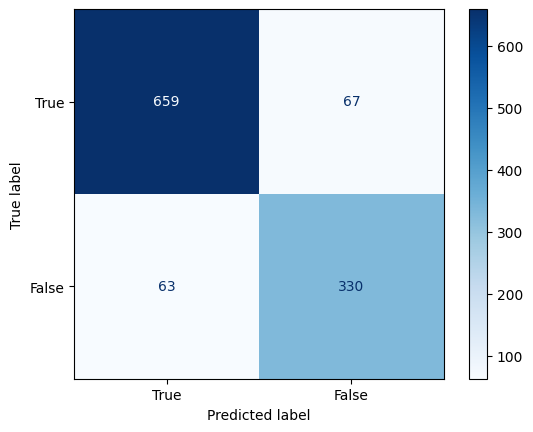

In [168]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test,y_pred_test), display_labels = ['True', 'False'])
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()